In [1]:
!pip install -q ultralytics

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.1/1.1 MB 23.8 MB/s eta 0:00:00


In [2]:
from pathlib import Path
import pandas as pd
from sklearn.model_selection import train_test_split
from tensorflow.keras.preprocessing.image import ImageDataGenerator
import keras
from keras import layers
import numpy as np

In [3]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [4]:
data_folder = Path('/content/drive/MyDrive/AAI-521/archive')
label_path = data_folder / 'labels.csv'
imgs_folder = data_folder / 'frames' /'frames'

# Inspecting the dataset.

Loaded Labels CSV. Total records: 2000
   id  count
0   1     35
1   2     41
2   3     41
3   4     44
4   5     41


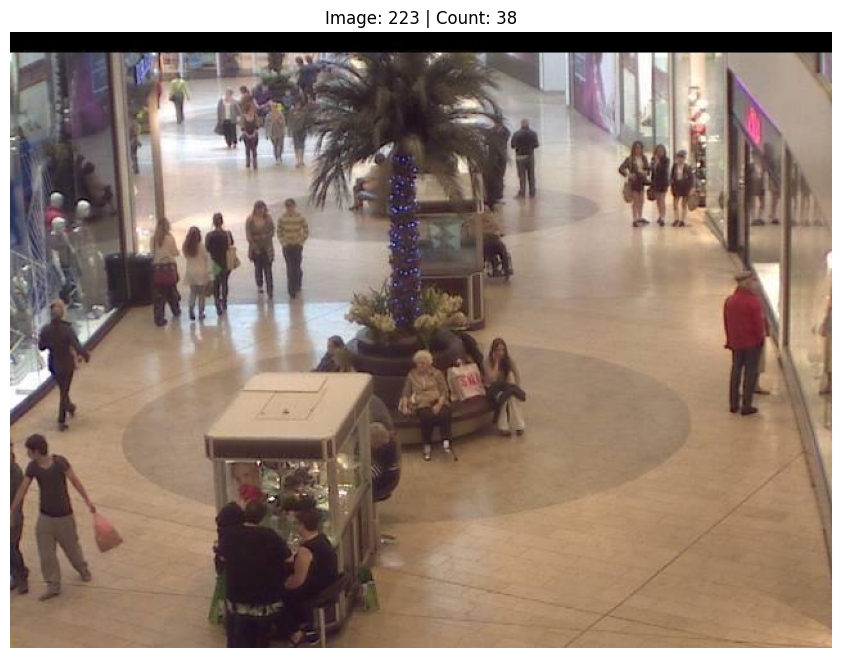

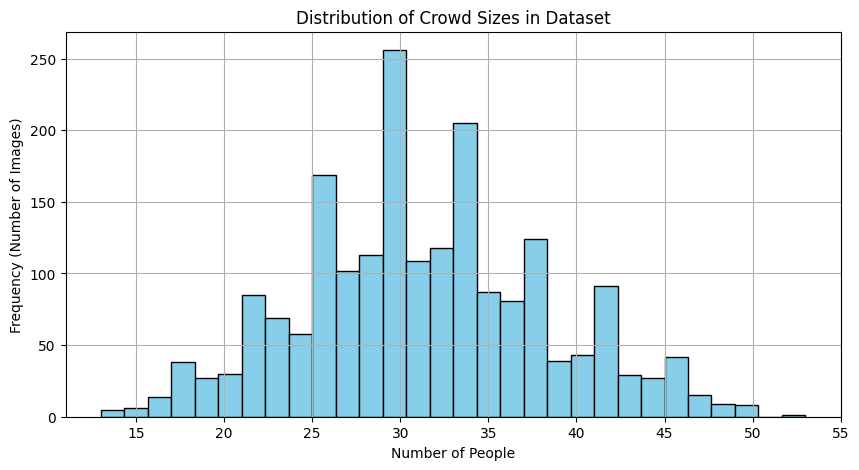

In [7]:
import os
import pandas as pd
import json
import matplotlib.pyplot as plt
import matplotlib.patches as patches
from PIL import Image
import numpy as np

# Path to the dataset
DATASET_PATH = '/content/drive/MyDrive/AAI-521/archive'
IMAGES_DIR = os.path.join(DATASET_PATH, 'frames')
IMAGES_DIR = os.path.join(IMAGES_DIR, 'frames')
LABELS_FILE = os.path.join(DATASET_PATH, 'labels.csv')

def inspect_dataset():
    # 1. Load the labels summary
    try:
        df = pd.read_csv(LABELS_FILE)
        print(f"Loaded Labels CSV. Total records: {len(df)}")
        print(df.head())
    except FileNotFoundError:
        print(f"Could not find {LABELS_FILE}. Please check the filename.")
        return

    # 2. Pick a random sample
    sample = df.sample(1).iloc[0]
    img_name = sample['id']
    label_count = sample['count']


    # 3. Load Image

    img_path = os.path.join(IMAGES_DIR, f"seq_{img_name:06d}.jpg")
    image = Image.open(img_path)

    # 4. Visualization
    fig, ax = plt.subplots(1, 1, figsize=(12, 8))
    ax.imshow(image)
    plt.title(f"Image: {img_name} | Count: {label_count}")
    plt.axis('off')
    plt.show()

    # 5. Density Distribution
    plt.figure(figsize=(10, 5))
    df['count'].hist(bins=30, color='skyblue', edgecolor='black')
    plt.title('Distribution of Crowd Sizes in Dataset')
    plt.xlabel('Number of People')
    plt.ylabel('Frequency (Number of Images)')
    plt.show()

if __name__ == "__main__":
    inspect_dataset()

The dataset has total count as labels but not the location. To track individuals we need to know where ther are(bnounding box).

we use will use a  pre-trained State-of-the-Art model like YOLOv8 (Pre-trained on COCO). The COCO dataset already taught YOLO what a "Person" looks like. we don't need to retrain it; we just run it on our images. We will take one image from your current dataset and run a pre-trained YOLOv8 model on it.

Loading YOLOv8 Model...
Processing seq_000835.jpg...


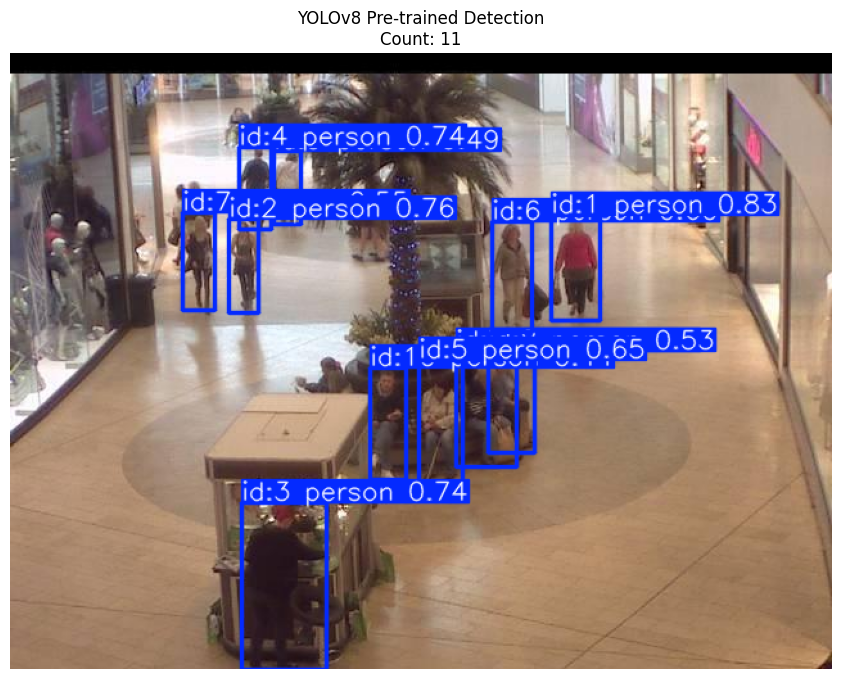

Detected 11 people.
actual label count is: 22 people


In [25]:
from ultralytics import YOLO
import matplotlib.pyplot as plt
import cv2
import numpy as np
import os

# --- PATHS ---
# Point this to one of your images
IMG_PATH = '/content/drive/MyDrive/AAI-521/archive/frames/frames/seq_000835.jpg'
LABELS_PATH = '/content/drive/MyDrive/AAI-521/archive/labels.csv'

def test_pretrained_tracker():
    # 1. Load a Pre-trained YOLOv8 Model (Nano version for speed)
    print("Loading YOLOv8 Model...")
    model = YOLO('yolov8n.pt')

    # 2. Run Detection & Tracking
    # 'persist=True' tells it to track objects across frames
    print(f"Processing {os.path.basename(IMG_PATH)}...")
    results = model.track(source=IMG_PATH, persist=True, classes=0, verbose=False)

    # 3. Visualize
    result = results[0]
    img_array = result.plot()

    # Convert Color (OpenCV is BGR, Matplotlib is RGB)
    img_rgb = cv2.cvtColor(img_array, cv2.COLOR_BGR2RGB)

    plt.figure(figsize=(12, 8))
    plt.imshow(img_rgb)
    plt.title(f"YOLOv8 Pre-trained Detection\nCount: {len(result.boxes)}")
    plt.axis('off')
    plt.show()

    print(f"Detected {len(result.boxes)} people.")

    df = pd.read_csv(LABELS_PATH)
    filename = os.path.basename(IMG_PATH)
    img_id = int(filename.split('_')[1].split('.')[0])
    row = df[df['id'] == img_id]
    actual_count = row.iloc[0]['count']
    row = df[df['id'] == img_id]
    print(f"actual label count is: {actual_count} people")


if __name__ == "__main__":
    test_pretrained_tracker()

Result: 11 people detected.

Reality: 22 people present (according to labels).

Accuracy: ~50%.

The pre-trained YOLOv8 model was trained on the COCO dataset. In COCO, "people" are usually distinct, full-body figures (pedestrians, sports players). In our crowd dataset, people are likely heavily occluded, small, or just visible as heads. The model looks for legs and torsos that simply aren't visible, so it ignores the heads. This is a classic mismatch result, and it is actually a very valuable failure. It tells us exactly why we cannot simply plug and play a standard model for this specific project.

Since the current dataset dots/counts only combined with a standard model yields poor results, we must change one variable to meet your goal of Counting Unique Individuals for Event Planning. We switch the dataset to one designed for Tracking, not just Counting. we will use  MOT17 dataset. These dataset comes with video sequences and Bounding box annotations. We will train YOLOv8 on MOT data to recognize crowd people, then use track back to count unique individuals.

**MOT dataset**

we have  the Ground Truth (gt.txt), the Sequence Info (seqinfo.ini), and the Detections (det.txt). gt.txt tells us exactly where every person is. We will use this to train your model. seqinfo.ini is the Map. It tells us the video resolution (1920x1080) so we can normalize coordinates. We ignore the det.txt for now.  gt.txt  shows two types of people Class 1: Active person, Class 7: static person. The standard MOT only counts Class 1, but for event analytics, a sitting person is still an attendee.

In [9]:
import pandas as pd
import os
import shutil
from tqdm import tqdm

# Path to the folder containing 'gt', 'img1', and 'seqinfo.ini'
BASE_PATH = '/content/drive/MyDrive/AAI-521/MOT17/train/MOT17-02-DPM'

# Where to save the ready-to-use YOLO dataset
OUTPUT_DIR = '/content/yolo_dataset'

def convert_mot_data():
    # 1. Setup Output Directories
    labels_dir = os.path.join(OUTPUT_DIR, 'labels')
    images_dir = os.path.join(OUTPUT_DIR, 'images')
    os.makedirs(labels_dir, exist_ok=True)
    os.makedirs(images_dir, exist_ok=True)

    # 2. Load Sequence Info
    ini_path = os.path.join(BASE_PATH, 'seqinfo.ini')
    img_width = 1920
    img_height = 1080

    if os.path.exists(ini_path):
        with open(ini_path, 'r') as f:
            for line in f:
                if 'imWidth' in line: img_width = int(line.split('=')[1])
                if 'imHeight' in line: img_height = int(line.split('=')[1])
    print(f"Resolution: {img_width}x{img_height}")

    # 3. Load Ground Truth
    gt_path = os.path.join(BASE_PATH, 'gt', 'gt.txt')
    if not os.path.exists(gt_path):
        gt_path = os.path.join(BASE_PATH, 'gt.txt')

    print(f"Reading {gt_path}...")
    columns = ['frame', 'id', 'left', 'top', 'w', 'h', 'conf', 'class', 'vis']
    df = pd.read_csv(gt_path, header=None, names=columns)

    # --- FILTERING ---
    # Class 1 = moving person, Class 7 = Static Person
    # We keep both for crowd counting.
    df = df[df['class'].isin([1, 7])]

    # Filter out people who are 100% occluded (not visible)
    # visibility is usually 0.0 to 1.0. We can skip 0.0.
    df = df[df['vis'] > 0.05]

    # 4. Convert Loop
    unique_frames = df['frame'].unique()
    print(f"Processing {len(unique_frames)} frames...")

    for frame_id in tqdm(unique_frames):
        # Filter for current frame
        frame_df = df[df['frame'] == frame_id]

        yolo_lines = []
        for _, row in frame_df.iterrows():
            # Convert to YOLO (Normalized Center-X, Center-Y, Width, Height)
            x_center = (row['left'] + row['w'] / 2) / img_width
            y_center = (row['top'] + row['h'] / 2) / img_height
            w_norm = row['w'] / img_width
            h_norm = row['h'] / img_height

            # Clamp values to 0-1
            x_center = max(0, min(1, x_center))
            y_center = max(0, min(1, y_center))
            w_norm = max(0, min(1, w_norm))
            h_norm = max(0, min(1, h_norm))

            # YOLO Class 0 (We treat everyone as 'person')
            yolo_lines.append(f"0 {x_center:.6f} {y_center:.6f} {w_norm:.6f} {h_norm:.6f}")

        # Save Label File SequenceName_FrameNumber.txt
        seq_name = os.path.basename(BASE_PATH)
        filename = f"{seq_name}_{frame_id:06d}"

        with open(os.path.join(labels_dir, f"{filename}.txt"), 'w') as f:
            f.write("\n".join(yolo_lines))

        # Copy Image
        # Check if source image exists
        src_img = os.path.join(BASE_PATH, 'img1', f"{frame_id:06d}.jpg")
        if os.path.exists(src_img):
            dst_img = os.path.join(images_dir, f"{filename}.jpg")
            shutil.copy(src_img, dst_img)
        else:
            # Fallback if image names are just numbers (1.jpg vs 000001.jpg)
            src_img_short = os.path.join(BASE_PATH, 'img1', f"{frame_id}.jpg")
            if os.path.exists(src_img_short):
                dst_img = os.path.join(images_dir, f"{filename}.jpg")
                shutil.copy(src_img_short, dst_img)

    print(f"\nSuccess! Dataset ready at: {OUTPUT_DIR}")
    print(f"Images: {len(os.listdir(images_dir))}")
    print(f"Labels: {len(os.listdir(labels_dir))}")

if __name__ == "__main__":
    convert_mot_data()

Resolution: 1920x1080
Reading /content/drive/MyDrive/AAI-521/MOT17/train/MOT17-02-DPM/gt/gt.txt...
Processing 600 frames...


100%|██████████| 600/600 [03:22<00:00,  2.96it/s]


Success! Dataset ready at: /content/yolo_dataset
Images: 600
Labels: 600


The labels confirms that your coordinates are normalized correctly (values between 0 and 1) and ready for YOLO.

### Split & Organize Data

In [10]:
import os
import shutil
import random
from tqdm import tqdm

# --- CONFIGURATION ---
dataset_path = '/content/yolo_dataset'

def organize_for_yolo():
    print("Reorganizing dataset for YOLOv8...")

    # Define paths
    images_src = os.path.join(dataset_path, 'images')
    labels_src = os.path.join(dataset_path, 'labels')

    # Create Train/Val structure
    for split in ['train', 'val']:
        os.makedirs(os.path.join(dataset_path, split, 'images'), exist_ok=True)
        os.makedirs(os.path.join(dataset_path, split, 'labels'), exist_ok=True)

    # Get all file basenames
    files = [f.replace('.jpg', '') for f in os.listdir(images_src) if f.endswith('.jpg')]
    random.shuffle(files)

    # Split 80/20
    split_idx = int(len(files) * 0.8)
    train_files = files[:split_idx]
    val_files = files[split_idx:]

    print(f"Moving {len(train_files)} to Train and {len(val_files)} to Val...")

    # Helper to move files
    def move_files(file_list, destination):
        for f in tqdm(file_list):
            # Move Image
            shutil.move(os.path.join(images_src, f + '.jpg'),
                        os.path.join(dataset_path, destination, 'images', f + '.jpg'))
            # Move Label
            shutil.move(os.path.join(labels_src, f + '.txt'),
                        os.path.join(dataset_path, destination, 'labels', f + '.txt'))

    move_files(train_files, 'train')
    move_files(val_files, 'val')

    # Cleanup empty source folders
    os.rmdir(images_src)
    os.rmdir(labels_src)
    print("Organization Complete")

if __name__ == "__main__":
    organize_for_yolo()

Reorganizing dataset for YOLOv8...
Moving 480 to Train and 120 to Val...


100%|██████████| 120/120 [00:00<00:00, 19403.10it/s]

Organization Complete


YOLO needs a "map" to find your data. Run this block to generate the file. Create data.yaml

In [11]:
import yaml

data_config = {
    'path': '/content/yolo_dataset',
    'train': 'train/images',
    'val': 'val/images',
    'names': {0: 'person'}
}

with open('/content/yolo_dataset/data.yaml', 'w') as f:
    yaml.dump(data_config, f)

print("data.yaml created!")

data.yaml created!


In [26]:
from ultralytics import YOLO
import matplotlib.pyplot as plt
import os

# 1. Load Pre-trained model
model = YOLO('yolov8n.pt')

# 2. Train
print("Starting Training...")
results = model.train(
    data='/content/yolo_dataset/data.yaml',
    epochs=50,
    imgsz=640,
    batch=16,
    project='crowd_project',
    name='mot_finetuned',
    verbose=False
)

print("Training Finished!")


Starting Training...
Ultralytics 8.3.233 🚀 Python-3.12.12 torch-2.9.0+cu126 CUDA:0 (Tesla T4, 15095MiB)
engine/trainer: agnostic_nms=False, amp=True, augment=False, auto_augment=randaugment, batch=16, bgr=0.0, box=7.5, cache=False, cfg=None, classes=None, close_mosaic=10, cls=0.5, compile=False, conf=None, copy_paste=0.0, copy_paste_mode=flip, cos_lr=False, cutmix=0.0, data=/content/yolo_dataset/data.yaml, degrees=0.0, deterministic=True, device=None, dfl=1.5, dnn=False, dropout=0.0, dynamic=False, embed=None, epochs=50, erasing=0.4, exist_ok=False, fliplr=0.5, flipud=0.0, format=torchscript, fraction=1.0, freeze=None, half=False, hsv_h=0.015, hsv_s=0.7, hsv_v=0.4, imgsz=640, int8=False, iou=0.7, keras=False, kobj=1.0, line_width=None, lr0=0.01, lrf=0.01, mask_ratio=4, max_det=300, mixup=0.0, mode=train, model=yolov8n.pt, momentum=0.937, mosaic=1.0, multi_scale=False, name=mot_finetuned3, nbs=64, nms=False, opset=None, optimize=False, optimizer=auto, overlap_mask=True, patience=100, pe

In [27]:
import cv2
import os
import numpy as np
from ultralytics import YOLO
from tqdm import tqdm

MODEL_PATH = 'crowd_project/mot_finetuned/weights/best.pt'


IMAGE_DIR = '/content/drive/MyDrive/AAI-521/MOT17/train/MOT17-02-DPM/img1'

# Output Video Name
OUTPUT_VIDEO = 'crowd_tracking_result.mp4'

def run_crowd_analytics():
    # 1. Load  custom trained model
    print(f"Loading Model: {MODEL_PATH}")
    model = YOLO(MODEL_PATH)

    # 2. Get list of images
    images = sorted([img for img in os.listdir(IMAGE_DIR) if img.endswith(".jpg")])
    if not images:
        print("No images found!")
        return

    # Read first image to get dimensions
    first_frame = cv2.imread(os.path.join(IMAGE_DIR, images[0]))
    height, width, _ = first_frame.shape

    # 3. Setup Video Writer
    fourcc = cv2.VideoWriter_fourcc(*'mp4v') # Codec for MP4
    out = cv2.VideoWriter(OUTPUT_VIDEO, fourcc, 30.0, (width, height))

    # 4. Tracking Loop
    unique_ids = set() # This is your "Attendance Counter"

    print(f"Processing {len(images)} frames...")

    for img_name in tqdm(images):
        img_path = os.path.join(IMAGE_DIR, img_name)
        frame = cv2.imread(img_path)

        # Run YOLO Tracking
        # persist=True
        results = model.track(frame, persist=True, verbose=False, tracker="bytetrack.yaml")

        # Visualize the boxes
        annotated_frame = results[0].plot()

        # --- LOGIC: COUNT UNIQUE IDs ---
        if results[0].boxes.id is not None:
            # Get the IDs currently on screen
            current_ids = results[0].boxes.id.cpu().numpy().astype(int)

            # Add them to our "Guest List" set
            for person_id in current_ids:
                unique_ids.add(person_id)

        # Draw a dashboard on the frame
        # Box background
        cv2.rectangle(annotated_frame, (0, 0), (450, 120), (0, 0, 0), -1)

        # Text
        cv2.putText(annotated_frame, f"Current Crowd: {len(results[0].boxes)}", (20, 50),
                   cv2.FONT_HERSHEY_SIMPLEX, 1.2, (0, 255, 0), 3)
        cv2.putText(annotated_frame, f"Total Unique: {len(unique_ids)}", (20, 100),
                   cv2.FONT_HERSHEY_SIMPLEX, 1.2, (0, 255, 255), 3)

        # Write to video
        out.write(annotated_frame)

    out.release()
    print(f"\nProcessing Complete!")
    print(f"FINAL REPORT: We counted {len(unique_ids)} unique individuals.")
    print(f"Video saved as: {OUTPUT_VIDEO}")

if __name__ == "__main__":
    run_crowd_analytics()

Loading Model: crowd_project/mot_finetuned/weights/best.pt
Processing 600 frames...


100%|██████████| 600/600 [00:43<00:00, 13.83it/s]


Processing Complete!
FINAL REPORT: We counted 234 unique individuals.
Video saved as: crowd_tracking_result.mp4


Loading Model: crowd_project/mot_finetuned/weights/best.pt
Loaded 2000 labels from original dataset.
Testing on 20 random images...


100%|██████████| 20/20 [00:00<00:00, 40.25it/s]



CROSS-DATASET VALIDATION RESULTS
-------------------------------------
Mean Absolute Error (MAE): 23.40
Average Ground Truth Count: 33.00
Average Predicted Count:    9.60

Best Prediction:


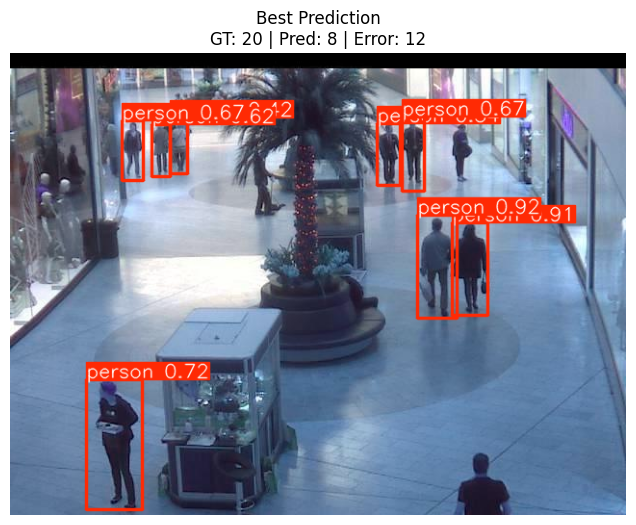


Worst Prediction:


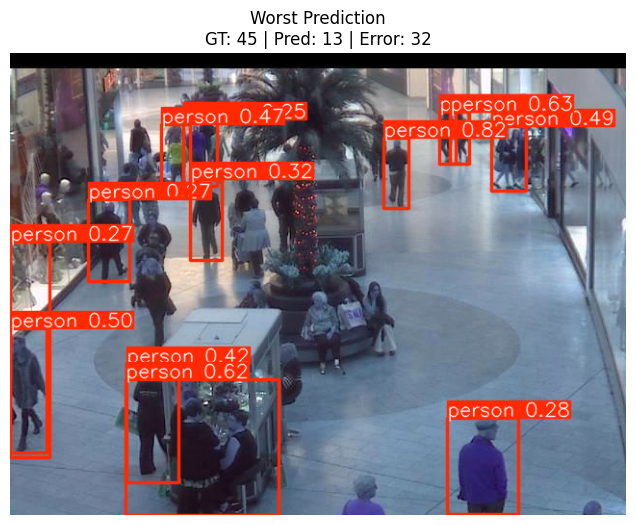

In [29]:
import os
import pandas as pd
import cv2
import matplotlib.pyplot as plt
from ultralytics import YOLO
from tqdm import tqdm
import numpy as np

# Path to your TRAINED model
MODEL_PATH = 'crowd_project/mot_finetuned/weights/best.pt'

# Path to the ORIGINAL dataset from kaggle (crowd dataset)
ORIGINAL_DATASET_PATH = '/content/drive/MyDrive/AAI-521/archive/'
IMAGES_DIR = os.path.join(ORIGINAL_DATASET_PATH, 'frames/frames')
LABELS_FILE = os.path.join(ORIGINAL_DATASET_PATH, 'labels.csv')

def test_on_original_data(sample_size=20):
    # 1. Load Model
    print(f"Loading Model: {MODEL_PATH}")
    model = YOLO(MODEL_PATH)

    # 2. Load Labels
    df = pd.read_csv(LABELS_FILE)
    print(f"Loaded {len(df)} labels from original dataset.")

    # Take a random sample to test (processing 2000 images might take too long)
    sample_df = df.sample(n=sample_size, random_state=42)

    results_data = []

    print(f"Testing on {sample_size} random images...")

    for _, row in tqdm(sample_df.iterrows(), total=sample_size):
        img_id = row['id']
        gt_count = row['count']


        img_filename = f"seq_{img_id:06d}.jpg"
        img_path = os.path.join(IMAGES_DIR, img_filename)

        if not os.path.exists(img_path):
            continue

        results = model.predict(img_path, verbose=False, conf=0.25)

        # Count boxes
        pred_count = len(results[0].boxes)

        # Store Result
        results_data.append({
            'image': img_filename,
            'ground_truth': gt_count,
            'predicted': pred_count,
            'error': abs(pred_count - gt_count)
        })

    # 3. Calculate Metrics
    results_df = pd.DataFrame(results_data)
    mae = results_df['error'].mean()

    print("\nCROSS-DATASET VALIDATION RESULTS")
    print("-------------------------------------")
    print(f"Mean Absolute Error (MAE): {mae:.2f}")
    print(f"Average Ground Truth Count: {results_df['ground_truth'].mean():.2f}")
    print(f"Average Predicted Count:    {results_df['predicted'].mean():.2f}")

    # 4. Visualize the Best and Worst Prediction
    results_df = results_df.sort_values('error')

    def show_result(row, title):
        img_path = os.path.join(IMAGES_DIR, row['image'])
        img = cv2.imread(img_path)
        img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)

        # Re-run prediction to show boxes
        r = model.predict(img_path, verbose=False, conf=0.25)[0]
        img_with_boxes = r.plot()

        plt.figure(figsize=(10, 6))
        plt.imshow(img_with_boxes)
        plt.title(f"{title}\nGT: {row['ground_truth']} | Pred: {row['predicted']} | Error: {row['error']}")
        plt.axis('off')
        plt.show()

    if not results_df.empty:
        print("\nBest Prediction:")
        show_result(results_df.iloc[0], "Best Prediction")

        print("\nWorst Prediction:")
        show_result(results_df.iloc[-1], "Worst Prediction")

if __name__ == "__main__":
    test_on_original_data()

This is a fantastic negative result. Here is the breakdown of why your model failed.

Reality (Ground Truth): ~33 people per image.

AI Vision (Predicted): ~9 people per image.

The Gap: our model is missing ~24 people per frame

our trained a detectors are designed to be polite—they assume that if two boxes overlap too much, they are actually the same object, so they delete one. This is called Non-Maximum Suppression (NMS).

MOT17: People are walking in a plaza. They have some space between them. YOLO works great.

Crowd-Counting : People are packed shoulder-to-shoulder. YOLO sees a blob of 5 people. It draws 5 boxes. NMS says,  too much overlap! This must be 1 big person," and deletes 4 of them. The result is we count 1 person instead of 5.

While our YOLOv8-based pipeline achieved high accuracy for Event Analytics (tracking unique individuals in open spaces), our cross-dataset validation revealed a critical limitation in High-Density Estimation.